In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from scipy.spatial.distance import cdist
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm


In [3]:


df = pd.read_csv("mcdonalds.csv")  

# Display dataset info
print(df.columns)  
print(df.shape)    
print(df.head(3)) 


Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [4]:
import numpy as np

# Convert the first 11 columns to binary (Yes -> 1, No -> 0)
MD_x = (df.iloc[:, :11] == "Yes").astype(int).to_numpy()

# Verify the transformation
print(MD_x[:3])  # Display the first 3 rows


[[0 1 0 1 0 1 1 0 1 0 0]
 [1 1 0 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 0 1 1 1 0]]


In [5]:
print(type(MD_x))

<class 'numpy.ndarray'>


In [6]:
# Compute column means
col_means = np.round(MD_x.mean(axis=0), 2)
print(col_means)


[0.55 0.91 0.09 0.87 0.53 0.9  0.6  0.64 0.36 0.2  0.24]


In [7]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

# PCA summary
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)
print("PCA Components:\n", np.round(pca.components_, 1))


Explained Variance Ratio: [0.29944723 0.19279721 0.13304535 0.08309578 0.05948052 0.05029956
 0.0438491  0.03954779 0.0367609  0.03235329 0.02932326]
PCA Components:
 [[ 0.5  0.2  0.  -0.1 -0.3  0.1  0.3  0.5 -0.3  0.2 -0.4]
 [-0.4 -0.  -0.   0.   0.1  0.1  0.6 -0.3 -0.6 -0.1  0.1]
 [ 0.3  0.1  0.   0.3  0.8  0.1  0.1  0.3 -0.  -0.2  0.1]
 [ 0.1 -0.1  0.2 -0.4  0.3 -0.1  0.1 -0.   0.1  0.8  0.4]
 [ 0.3 -0.3 -0.1  0.1 -0.4 -0.1  0.1  0.2  0.  -0.3  0.7]
 [-0.2  0.3  0.4  0.4 -0.2  0.6  0.1  0.1  0.3  0.2  0.2]
 [-0.3 -0.1  0.7 -0.4  0.  -0.1 -0.   0.4 -0.1 -0.3 -0. ]
 [-0.   0.1 -0.4 -0.6  0.1  0.6 -0.1  0.1 -0.  -0.2  0.2]
 [-0.6  0.  -0.4  0.2  0.  -0.2 -0.1  0.6 -0.1  0.2  0.1]
 [ 0.1  0.7  0.1  0.  -0.  -0.2 -0.4 -0.1 -0.5  0.   0.3]
 [-0.   0.5 -0.1 -0.3 -0.  -0.3  0.5 -0.   0.5 -0.2  0. ]]


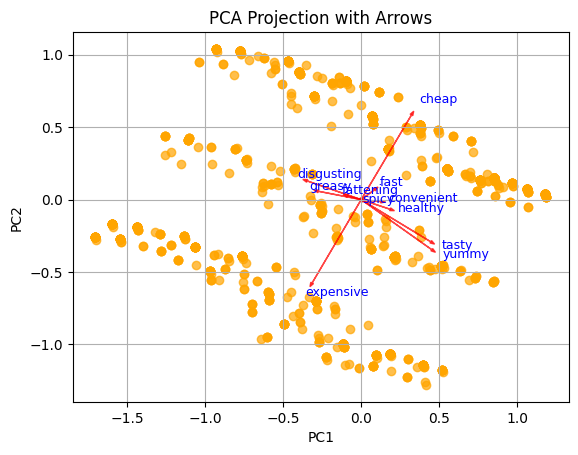

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `MD_pca` is the PCA-transformed data and `pca` is the PCA object
# pca.components_ contains the principal component loadings

features = df.columns[:11]  
loadings = pca.components_.T  # Transpose to align features with components

# Plot PCA projections
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color="orange", alpha=0.7)
plt.title("PCA Projection with Arrows")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()

# Add arrows for loadings
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
              color='red', alpha=0.7, head_width=0.02, length_includes_head=True)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, feature, color='blue', fontsize=9)

# Show the plot
plt.show()


In [9]:

np.random.seed(1234)
MD_x = pd.DataFrame(np.random.rand(100, 5), columns=[f"Feature_{i}" for i in range(1, 6)])


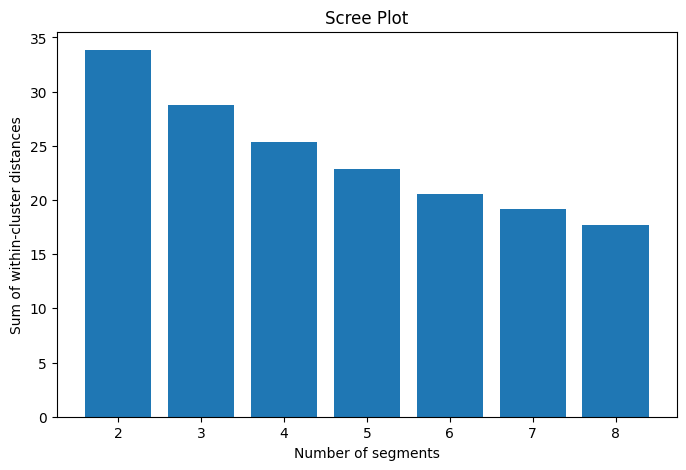

In [10]:
results = {}
inertia = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    results[k] = kmeans
    inertia.append(kmeans.inertia_)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.bar(range(2, 9), inertia)
plt.xlabel('Number of segments')
plt.ylabel('Sum of within-cluster distances')
plt.title('Scree Plot')
plt.show()


C:\Users\Hp\AppData\Local\Temp\ipykernel_13776\2817756875.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([stability_scores[k] for k in clusters_range], labels=clusters_range)


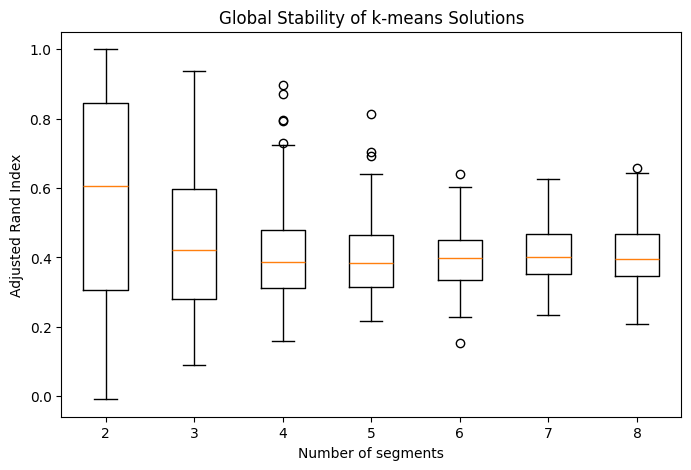

In [11]:
def calculate_global_stability(data, clusters_range, n_boot=100, n_rep=10):
    stability_scores = {k: [] for k in clusters_range}

    for k in clusters_range:
        for _ in range(n_boot):
            # Create a bootstrap sample
            sample = resample(data, random_state=np.random.randint(0, 10000))

            # Fit k-means on the sample
            kmeans = KMeans(n_clusters=k, n_init=n_rep, random_state=1234).fit(sample)

            stability_scores[k].append(
                adjusted_rand_score(kmeans.predict(data), results[k].predict(data))
            )

    return stability_scores

clusters_range = range(2, 9)
stability_scores = calculate_global_stability(MD_x, clusters_range)

# Global Stability Boxplot
plt.figure(figsize=(8, 5))
plt.boxplot([stability_scores[k] for k in clusters_range], labels=clusters_range)
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global Stability of k-means Solutions')
plt.show()


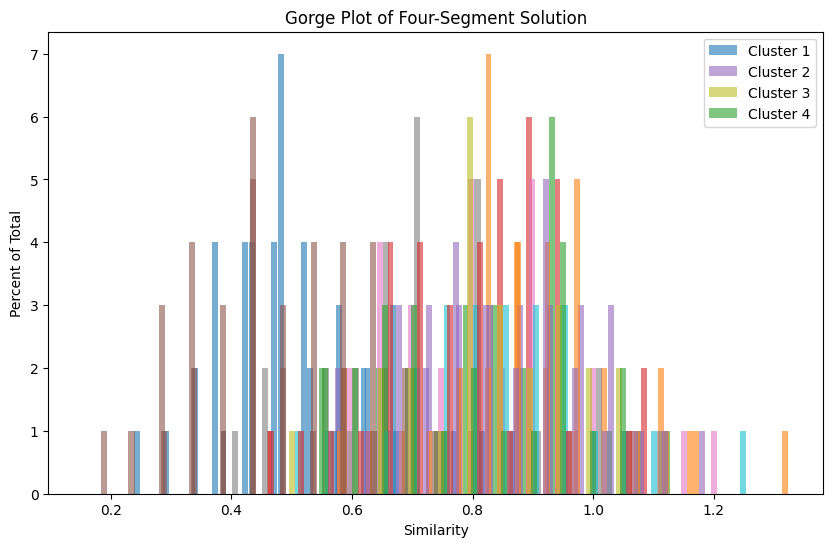

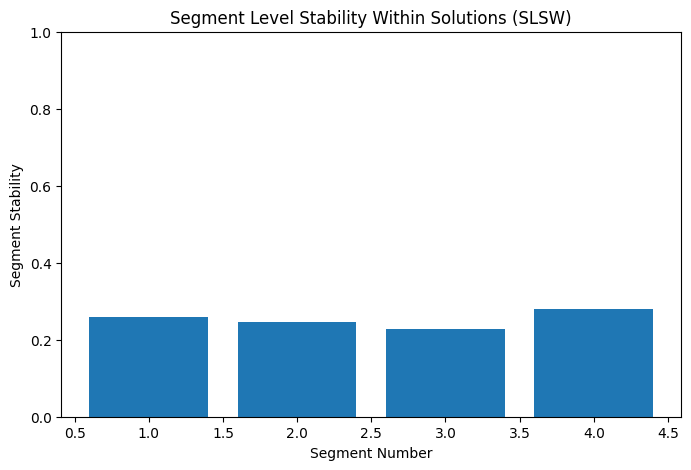

In [12]:
selected_k = 4
kmeans_selected = results[selected_k]

# Plot Histogram (Gorge Plot)
clusters = kmeans_selected.predict(MD_x)
plt.figure(figsize=(10, 6))
for cluster in range(selected_k):
    plt.hist(cdist(MD_x, kmeans_selected.cluster_centers_)[clusters == cluster], bins=20, alpha=0.6, label=f"Cluster {cluster + 1}")

plt.xlabel('Similarity')
plt.ylabel('Percent of Total')
plt.legend()
plt.title('Gorge Plot of Four-Segment Solution')
plt.show()

# Segment Level Stability Within Solutions (SLSW)
def calculate_segment_stability(data, kmeans, n_boot=100):
    segment_stability = []

    for cluster in range(kmeans.n_clusters):
        stability = []
        for _ in range(n_boot):
            sample = resample(data, random_state=np.random.randint(0, 10000))
            kmeans_sample = KMeans(n_clusters=kmeans.n_clusters, n_init=10, random_state=1234).fit(sample)
            cluster_labels = kmeans_sample.predict(data)
            stability.append(np.mean(cluster_labels == kmeans.labels_))
        segment_stability.append(np.mean(stability))

    return segment_stability

segment_stability = calculate_segment_stability(MD_x, kmeans_selected)

# Plot SLSW
plt.figure(figsize=(8, 5))
plt.bar(range(1, selected_k + 1), segment_stability)
plt.ylim(0, 1)
plt.xlabel('Segment Number')
plt.ylabel('Segment Stability')
plt.title('Segment Level Stability Within Solutions (SLSW)')
plt.show()


In [13]:
from sklearn.mixture import GaussianMixture

# Simulating binary data as input 
np.random.seed(1234)
MD_x = np.random.randint(2, size=(1000, 5))  

# Fit Gaussian Mixture Models for 2 to 8 components
results = {}
for n_components in range(2, 9):
    gmm = GaussianMixture(n_components=n_components, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    results[n_components] = {
        'model': gmm,
        'logLik': gmm.lower_bound_,
        'aic': gmm.aic(MD_x),
        'bic': gmm.bic(MD_x)
    }


In [14]:
# Display log-likelihood, AIC, and BIC for each number of components
for n_components, metrics in results.items():
    print(f"Components: {n_components}, Log-Lik: {metrics['logLik']:.2f}, "
          f"AIC: {metrics['aic']:.2f}, BIC: {metrics['bic']:.2f}")


Components: 2, Log-Lik: 2.40, AIC: -4727.83, BIC: -4526.61
Components: 3, Log-Lik: 5.51, AIC: -10893.86, BIC: -10589.58
Components: 4, Log-Lik: 8.43, AIC: -16694.67, BIC: -16287.33
Components: 5, Log-Lik: 9.83, AIC: -19459.60, BIC: -18949.20
Components: 6, Log-Lik: 10.78, AIC: -21300.50, BIC: -20687.03
Components: 7, Log-Lik: 12.85, AIC: -25417.02, BIC: -24700.49
Components: 8, Log-Lik: 14.45, AIC: -28572.03, BIC: -27752.43


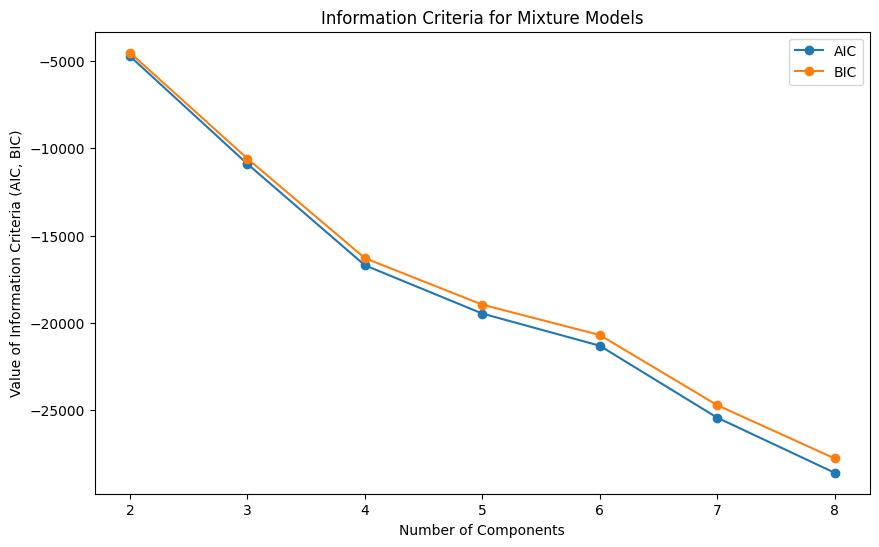

In [15]:
components = list(results.keys())
aic = [results[c]['aic'] for c in components]
bic = [results[c]['bic'] for c in components]

plt.figure(figsize=(10, 6))
plt.plot(components, aic, label="AIC", marker="o")
plt.plot(components, bic, label="BIC", marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Value of Information Criteria (AIC, BIC)")
plt.title("Information Criteria for Mixture Models")
plt.legend()
plt.show()


In [16]:
optimal_model = results[4]['model']
labels = optimal_model.predict(MD_x)


In [17]:
# Perform KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=1234, n_init=10)
kmeans_labels = kmeans.fit_predict(MD_x)

# Cross-tabulation
comparison_table = pd.crosstab(kmeans_labels, labels, rownames=['kmeans'], colnames=['mixture'])
print(comparison_table)


mixture    0    1    2    3
kmeans                     
0        192    0   53    0
1         37  236   34    0
2         34    0  166    0
3          0    0    0  248


In [18]:
# Reinitialize GMM with k-means labels
gmm_initialized = GaussianMixture(n_components=4, random_state=1234, n_init=1)
gmm_initialized.fit(MD_x, y=kmeans_labels)

# Cross-tabulation
initialized_labels = gmm_initialized.predict(MD_x)
comparison_table_initialized = pd.crosstab(kmeans_labels, initialized_labels, rownames=['kmeans'], colnames=['mixture'])
print(comparison_table_initialized)

# Log-likelihood comparison
print("Log-Likelihood with random initialization:", optimal_model.lower_bound_)
print("Log-Likelihood with k-means initialization:", gmm_initialized.lower_bound_)


mixture    0   1    2    3
kmeans                    
0         93  34    0  118
1        194   0    0  113
2         53   0    0  147
3        100  34  114    0
Log-Likelihood with random initialization: 8.430337009447202
Log-Likelihood with k-means initialization: 4.966286888861802


In [19]:
df['Like.n'] = 6 - df['Like'].map({
    "I LOVE IT!(+5)": 1, "+4": 2, "+3": 3, "+2": 4, "+1": 5,
    "0": 6, "-1": 7, "-2": 8, "-3": 9, "-4": 10, "I HATE IT!(-5)": 11
})

# Display the frequency table of the transformed variable
print(df['Like.n'].value_counts())


Like.n
 3.0    229
 2.0    187
 0.0    169
 4.0    160
 1.0    152
-3.0     73
-4.0     71
-2.0     59
-1.0     58
Name: count, dtype: int64


In [20]:
# Extracting independent variable names 
independent_vars = df.columns[:11]

# Creating the regression formula for 'Like.n' ~ independent variables
formula = "Like.n ~ " + " + ".join(independent_vars)
print("Regression Formula:", formula)


Regression Formula: Like.n ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting


In [21]:
# Extract dependent and independent variables
X = df[independent_vars].applymap(lambda x: 1 if x == "Yes" else 0)  # One-hot encoding 'Yes'/'No'
y = df['Like.n']

# Fit Gaussian Mixture Model 
gmm = GaussianMixture(n_components=2, random_state=1234, n_init=10)
clusters = gmm.fit_predict(X)

# Add cluster assignments to the DataFrame
df['Cluster'] = clusters
print("Cluster Sizes:", pd.Series(clusters).value_counts())


C:\Users\Hp\AppData\Local\Temp\ipykernel_13776\968766021.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = df[independent_vars].applymap(lambda x: 1 if x == "Yes" else 0)  # One-hot encoding 'Yes'/'No'


Cluster Sizes: 0    985
1    468
Name: count, dtype: int64


In [31]:
# Define a function to fit a regression model for each cluster
def fit_regression(X, y):
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X).fit()
    return model

# Fit models for each cluster
models = {}
for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster]
    X_cluster = cluster_data[independent_vars].applymap(lambda x: 1 if x == "Yes" else 0)
    y_cluster = cluster_data['Like.n']
    models[cluster] = fit_regression(X_cluster, y_cluster)
print(models)


C:\Users\Hp\AppData\Local\Temp\ipykernel_13776\3810547543.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_cluster = cluster_data[independent_vars].applymap(lambda x: 1 if x == "Yes" else 0)


{np.int64(0): <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001787C050620>, np.int64(1): <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001787C074F20>}


C:\Users\Hp\AppData\Local\Temp\ipykernel_13776\3810547543.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_cluster = cluster_data[independent_vars].applymap(lambda x: 1 if x == "Yes" else 0)
